# <center>CSCI 6516 - Machine Learning for Big Data</center><br><center>(Fall 2023)</center>

# <center>Assignment 1</center>

### Submitted by:
**Arihant Dugar**<br>
**B00917961**<br>
**ar968345@dal.ca**<br>

In [1]:
# All the import statements go below
import pandas as pd
import numpy as np
import sklearn
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

**[1] Your first task is to conduct research to identify appropriate resources for obtaining such data and to understand their format**

Traffic Dataset :
   SECTION ID  HIGHWAY  SECTION  SECTION LENGTH  \
0        1047        1       47             4.5   
1        1047        1       47             4.5   
2        1047        1       47             4.5   
3        1047        1       47             4.5   
4        1047        1       47             4.5   

                           SECTION DESCRIPTION        Date  \
0  PATTON RD (SACKVILLE) TO MOUNT UNIACKE CONN  06/20/2022   
1  PATTON RD (SACKVILLE) TO MOUNT UNIACKE CONN  05/27/2021   
2  PATTON RD (SACKVILLE) TO MOUNT UNIACKE CONN  05/27/2021   
3  PATTON RD (SACKVILLE) TO MOUNT UNIACKE CONN  05/27/2021   
4  PATTON RD (SACKVILLE) TO MOUNT UNIACKE CONN  11/24/2020   

                     DESCRIPTION GROUP TYPE COUNTY  PTRUCKS     ADT    AADT  \
0  0.5 KM EAST OF BRUSHY HILL RD     A   TC    HFX      NaN  2986.0  2760.0   
1    JUST WEST OF PATTON RD (EB)     A   VC    HFX      4.0  1396.0  1310.0   
2    JUST WEST OF PATTON RD (WB)     A   VC    HFX      4.0  1774

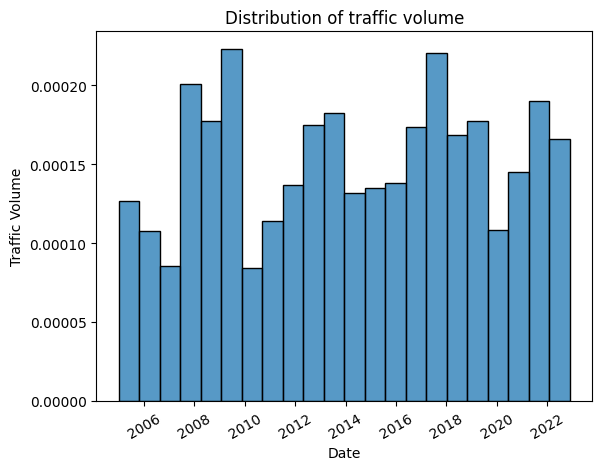



Pm2.5 Dataset :
              Date & time Pollutant   Unit  Station Instrument  Average  \
0  2006/01/01 01:00:00 AM     PM2.5  µg/m3  Halifax   BAM 1020      NaN   
1  2006/01/01 02:00:00 AM     PM2.5  µg/m3  Halifax   BAM 1020      NaN   
2  2006/01/01 03:00:00 AM     PM2.5  µg/m3  Halifax   BAM 1020      NaN   
3  2006/01/01 04:00:00 AM     PM2.5  µg/m3  Halifax   BAM 1020      NaN   
4  2006/01/01 05:00:00 AM     PM2.5  µg/m3  Halifax   BAM 1020      NaN   

         Date  
0  01/01/2006  
1  01/01/2006  
2  01/01/2006  
3  01/01/2006  
4  01/01/2006  


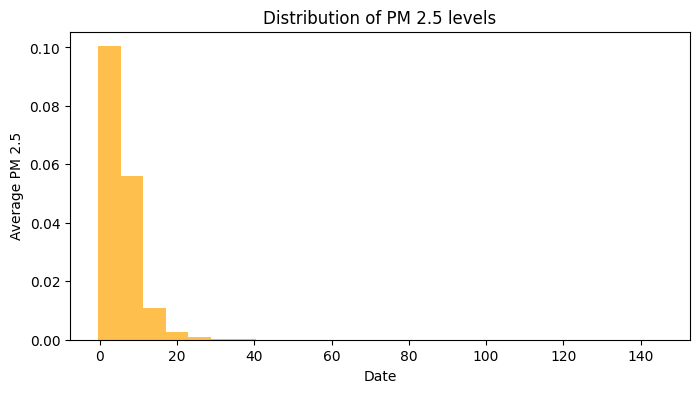

In [2]:
#Load the traffic dataset from the csv file
traffic_data = pd.read_csv("Traffic_Volumes_-_Provincial_Highway_System.csv")

#Data exploration and understanding the traffic datastet - print some values to understand the dataset
print("Traffic Dataset :")
print(traffic_data.head())

#See how the distribution of traffic volume
plt.figure()
sns.histplot(data=traffic_data, x=pd.to_datetime(traffic_data['Date']), stat="density")
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.title('Distribution of traffic volume')
plt.xticks(rotation=30)
plt.show()

#Load the pollutant dataset from the csv file
pollutant_data = pd.read_csv("Nova_Scotia_Provincial_Ambient_Fine_Particulate_Matter__PM2.5__Hourly_Data_Halifax_BAM_T640.csv")

#Convert the Date & Time from the pollutant dataset to Date format and store it in the Date column
pollutant_data['Date'] = pd.to_datetime(pollutant_data['Date & time'], format='%Y/%m/%d %I:%M:%S %p').dt.strftime('%m/%d/%Y')

#Data exploration and understanding the pm2.5 datastet - print some values to understand the dataset
print("\n\nPm2.5 Dataset :")
print(pollutant_data.head())

#See how the distribution of PM2.5 levels looks like
plt.figure(figsize=(8,4))
plt.hist(pollutant_data['Average'], bins=25, color="Orange", alpha=0.7, density=True)
plt.xlabel('Date')
plt.ylabel('Average PM 2.5')
plt.title('Distribution of PM 2.5 levels')
plt.show()

**[2] You will preprocess the PM2.5 data (recommended year: 2019) and the traffic data (in CSV format).**

**i. The traffic data needs to be filtered to represent the Halifax region**

In [3]:
#Filter the traffic dataset for values that are only for Halifax (HFX)
traffic_data = traffic_data[(traffic_data['COUNTY'] == 'HFX')]

**ii. The PM2.5 data will serve as labels for the traffic dataset, so you should compute the daily averages.**

In [4]:
#Linearly interpolate missing values in the 'Average' column
pollutant_data['Average'].interpolate(method='linear', inplace=True)

daily_avg_pm25 = pollutant_data.groupby('Date')['Average'].mean().reset_index()

#Drop the NaN values for Average in PM2.5 data
daily_avg_pm25.dropna(inplace=True)

#See how the daily average data looks like
daily_avg_pm25.head()

Date   Average
1  01/01/2007  6.576777
2  01/01/2008  2.291667
3  01/01/2009  6.696512
4  01/01/2010  4.562500
5  01/01/2011  4.214583

**iii. Subsequently, you must normalize the PM2.5 levels and discretize them using a threshold of 0.5. During this step, perform a descriptive analysis of your data to gain a better understanding of it. This process will result in a dataset that you can work with.** 

In [5]:
min_pm25 = daily_avg_pm25['Average'].min()
max_pm25 = daily_avg_pm25['Average'].max()

daily_avg_pm25['Normalized_Avg'] = (daily_avg_pm25['Average'] - min_pm25) / (max_pm25 - min_pm25)

# Discretize PM2.5 levels using a threshold of 0.5 and classify it as High or Low
threshold = 0.5
daily_avg_pm25['Discretized_Avg'] = daily_avg_pm25['Normalized_Avg'].apply(lambda x: 'High' if x > threshold else 'Low')

# Descriptive Analysis
# Calculate descriptive statistics
mean_pm25 = daily_avg_pm25['Average'].mean()
median_pm25 = daily_avg_pm25['Average'].median()
std_pm25 = daily_avg_pm25['Average'].std()

# Count the number of 'High' and 'Low' values in the discretized column
count_high = (daily_avg_pm25['Discretized_Avg'] == 'High').sum()
count_low = (daily_avg_pm25['Discretized_Avg'] == 'Low').sum()

# Print the descriptive statistics and counts
daily_avg_pm25['Average'].describe()

count    5731.000000
mean        5.855940
std         3.358716
min         0.000000
25%         3.550000
50%         5.212500
75%         7.404167
max        34.989583
Name: Average, dtype: float64

**Count:** There are 5731 data points in the 'Average' column, indicating the number of non-missing values.

**Mean:** The mean (average) value of the 'Average' column is approximately 5.86. This represents the central tendency of the data, suggesting that, on average, the values tend to be around 5.86.

**Standard Deviation:** The standard deviation is approximately 3.36. It measures the spread or variability of the data points. A higher standard deviation indicates greater variability around the mean.

**Minimum:** The minimum value in the 'Average' column is 0. This is the smallest observed value in the dataset.

**25th Percentile (Q1):** The 25th percentile value (Q1) is approximately 3.55. This means that 25% of the data points are less than or equal to 3.55.

**Median (50th Percentile):** The median value is approximately 5.21. It represents the middle value when the data is sorted in ascending order. Half of the data points are less than or equal to this value.

**75th Percentile (Q3):** The 75th percentile value (Q3) is approximately 7.40. This means that 75% of the data points are less than or equal to 7.40.

**Maximum:** The maximum value in the 'Average' column is 34.99. This is the largest observed value in the dataset.

**iv. Lastly, you should include one summary visualization of the data**

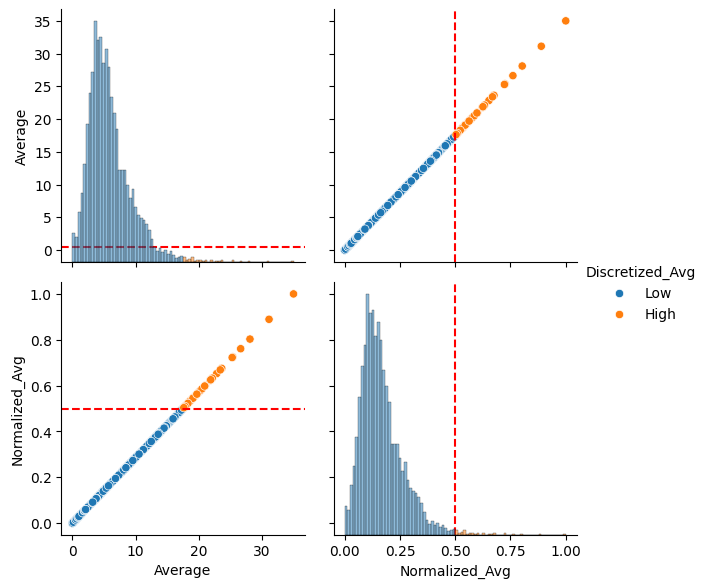

In [6]:
g = sns.PairGrid(data=daily_avg_pm25, height=3, hue='Discretized_Avg')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
for i, ax in enumerate(g.axes.flatten()):
    if i%2 == 1:
        ax.axvline(x=0.5, color='red', linestyle='--')
    elif i%2 == 0:
        ax.axhline(y=0.5, color='red', linestyle='--')

**[3] Answer the following questions:**

Performing Data pre processing - Merge the datasets on the Date column and fill or clean up the missing NaN values

In [7]:
merged_df = pd.merge(traffic_data, daily_avg_pm25, on='Date', how='inner')
#Check NaN values
display(merged_df.isna().sum())

#Fill ADT and AADT with median as it is effected or influenced by outliers
merged_df['ADT'].fillna(merged_df['ADT'].median(), inplace=True)
merged_df['AADT'].fillna(merged_df['ADT'].median(), inplace=True)

#Drop the columns as filling them is making the data extremely skewed
merged_df.drop(columns=['85PCT', 'PRIORITY_POINTS'], inplace=True)

#Filling the Direction values with random values from the column to see if we can use it and the data is meaningful or not
merged_df['DIRECTION'] = merged_df['DIRECTION'].apply(lambda x: np.random.choice(merged_df['DIRECTION'].dropna().unique()) if pd.isna(x) else x)

#Using back fill to replace NaN values in the group 
merged_df['GROUP'].bfill(inplace=True)

#Since PTUCKS has 1460 missing values (which is huge) checking if filling it using interpolation will allow us to use it
merged_df['PTRUCKS'].interpolate(method='linear', inplace=True)

SECTION ID                0
HIGHWAY                   0
SECTION                   0
SECTION LENGTH            0
SECTION DESCRIPTION       0
Date                      0
DESCRIPTION               0
GROUP                    24
TYPE                      0
COUNTY                    0
PTRUCKS                1460
ADT                     105
AADT                     23
DIRECTION               826
85PCT                  1942
PRIORITY_POINTS        2021
Average                   0
Normalized_Avg            0
Discretized_Avg           0
dtype: int64

In [8]:
#Drop values we do not need
#County is HFX for all and is not required
#We have merged the data on the Date column and it will not be used going forward so we can drop it
#PTRUCKS after interpolating seems to be extremely skewed so we will be dropping it as we cannot predict approx 80% 
# of the values that is dependent on something else
#Direction cannot be filled randomly as while verifying it did not make sense for a lot of data and it is dependent on the cordinates ..
#And we have incomplete information to fill the Direction
merged_df.drop(['Date','SECTION ID','COUNTY','PTRUCKS', 'DIRECTION'], axis=1, inplace=True)

#Verifying the NaN values after filling all the values and dropping columns we do not use
merged_df.isna().sum()

HIGHWAY                0
SECTION                0
SECTION LENGTH         0
SECTION DESCRIPTION    0
DESCRIPTION            0
GROUP                  0
TYPE                   0
ADT                    0
AADT                   0
Average                0
Normalized_Avg         0
Discretized_Avg        0
dtype: int64

**i. Use the Information Gain (IG) as the decision criterion to select which attribute to split on. Show your calculations for the IG for the root node.**

In [9]:

entropy = 0

low_probability = len(merged_df.query('Discretized_Avg == "Low"')) / len(merged_df)
entropy -= low_probability * math.log2(low_probability)
high_probability = len(merged_df.query('Discretized_Avg == "High"')) / len(merged_df)
entropy -= high_probability * math.log2(high_probability)

print('Entropy for the dataset is : {}'.format(entropy))


Entropy for the dataset is : 0.08280324079255713


In [10]:

print('\x1b[1;31m'+'Information Gain for each feature :'+'\x1b[0m')

for row in merged_df.iloc[:,:-3]:
    attr_entropy = 0
    for uniqval in np.unique(merged_df[row].values):
        unival_entropy = 0
        prob_high = len(merged_df[(merged_df[row] == uniqval) & (merged_df['Discretized_Avg'] == "High")]) / len(merged_df[(merged_df[row] == uniqval)])
        prob_low = len(merged_df[(merged_df[row] == uniqval) & (merged_df['Discretized_Avg'] == "Low")]) / len(merged_df[(merged_df[row] == uniqval)])
        prob_val = len(merged_df[(merged_df[row] == uniqval)]) / len(merged_df)
        if prob_high > 0:
            unival_entropy -= prob_high * math.log2(prob_high)
        if prob_low > 0 :
            unival_entropy -= prob_low * math.log2(prob_low)
        # Calculate Average entropy Information
        attr_entropy += unival_entropy * prob_val
    print("IG for {} is: {}".format(row,entropy-attr_entropy)) 




Information Gain for each feature :
IG for HIGHWAY is: 0.02097226275448029
IG for SECTION is: 0.00553242427755922
IG for SECTION LENGTH is: 0.030647958690728207
IG for SECTION DESCRIPTION is: 0.0306479586907282
IG for DESCRIPTION is: 0.04613354723910616
IG for GROUP is: 0.0029817396614718883
IG for TYPE is: 0.00046390793392427077
IG for ADT is: 0.0738906849393892
IG for AADT is: 0.053080175160931053


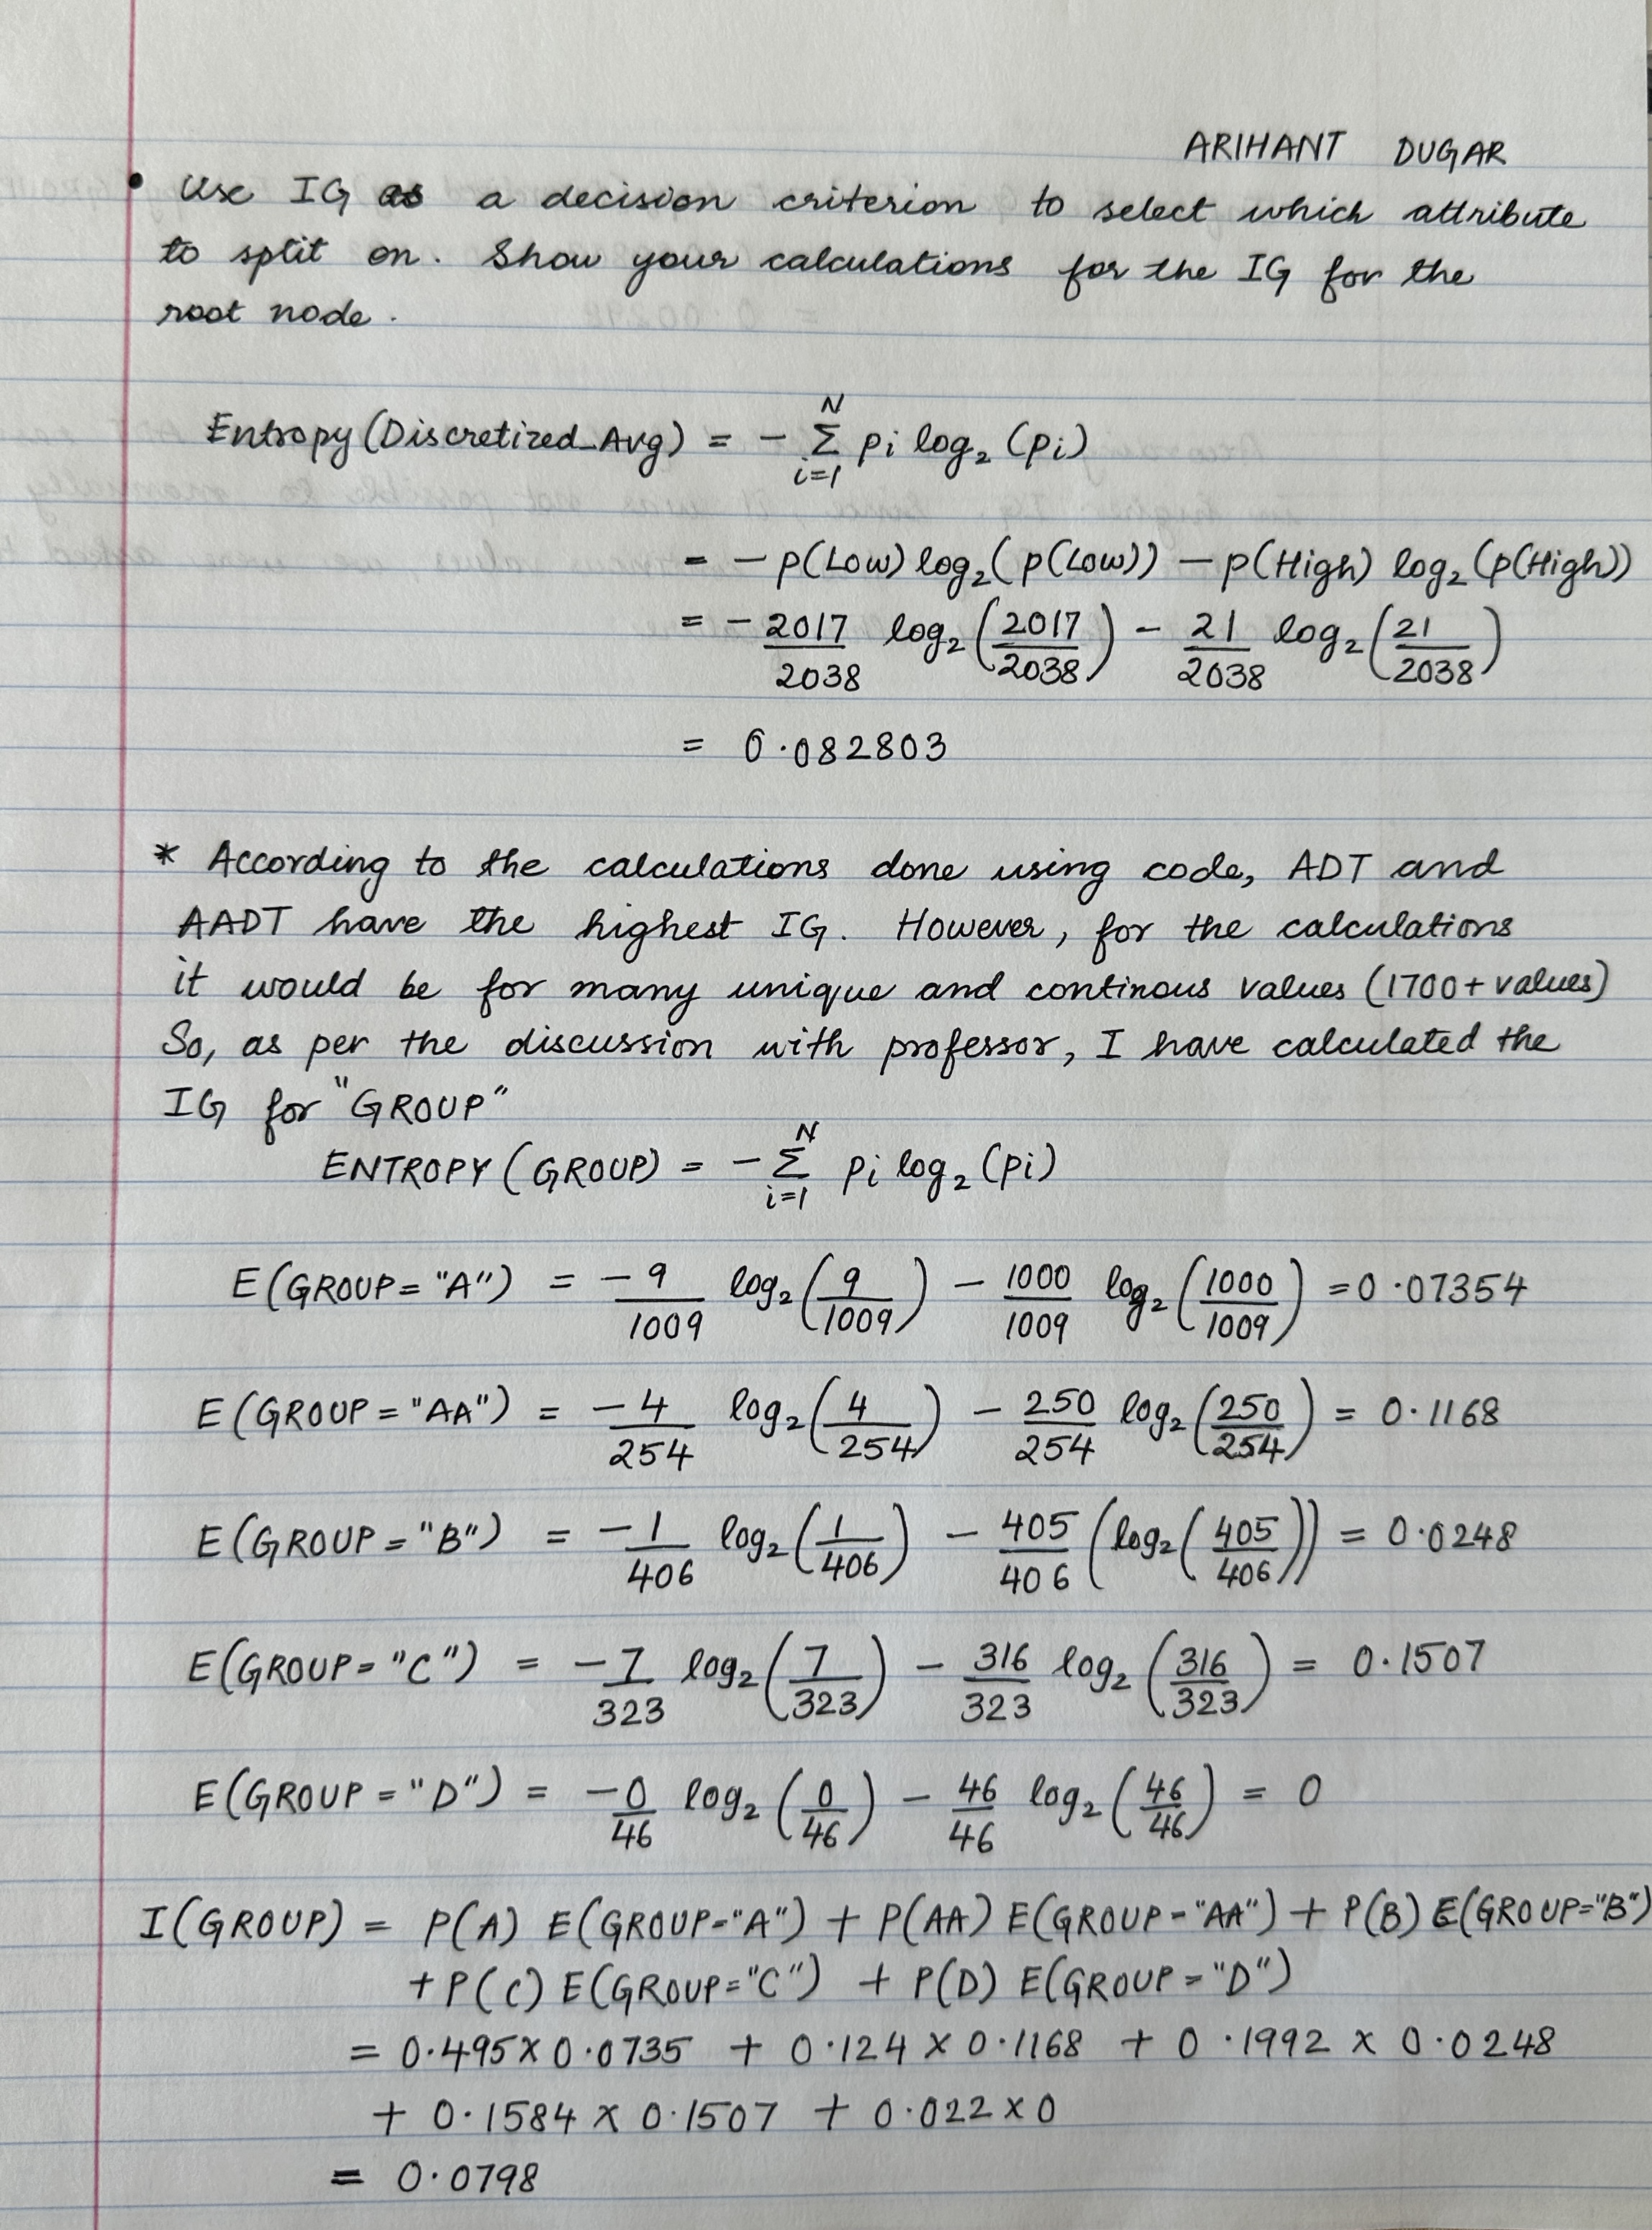

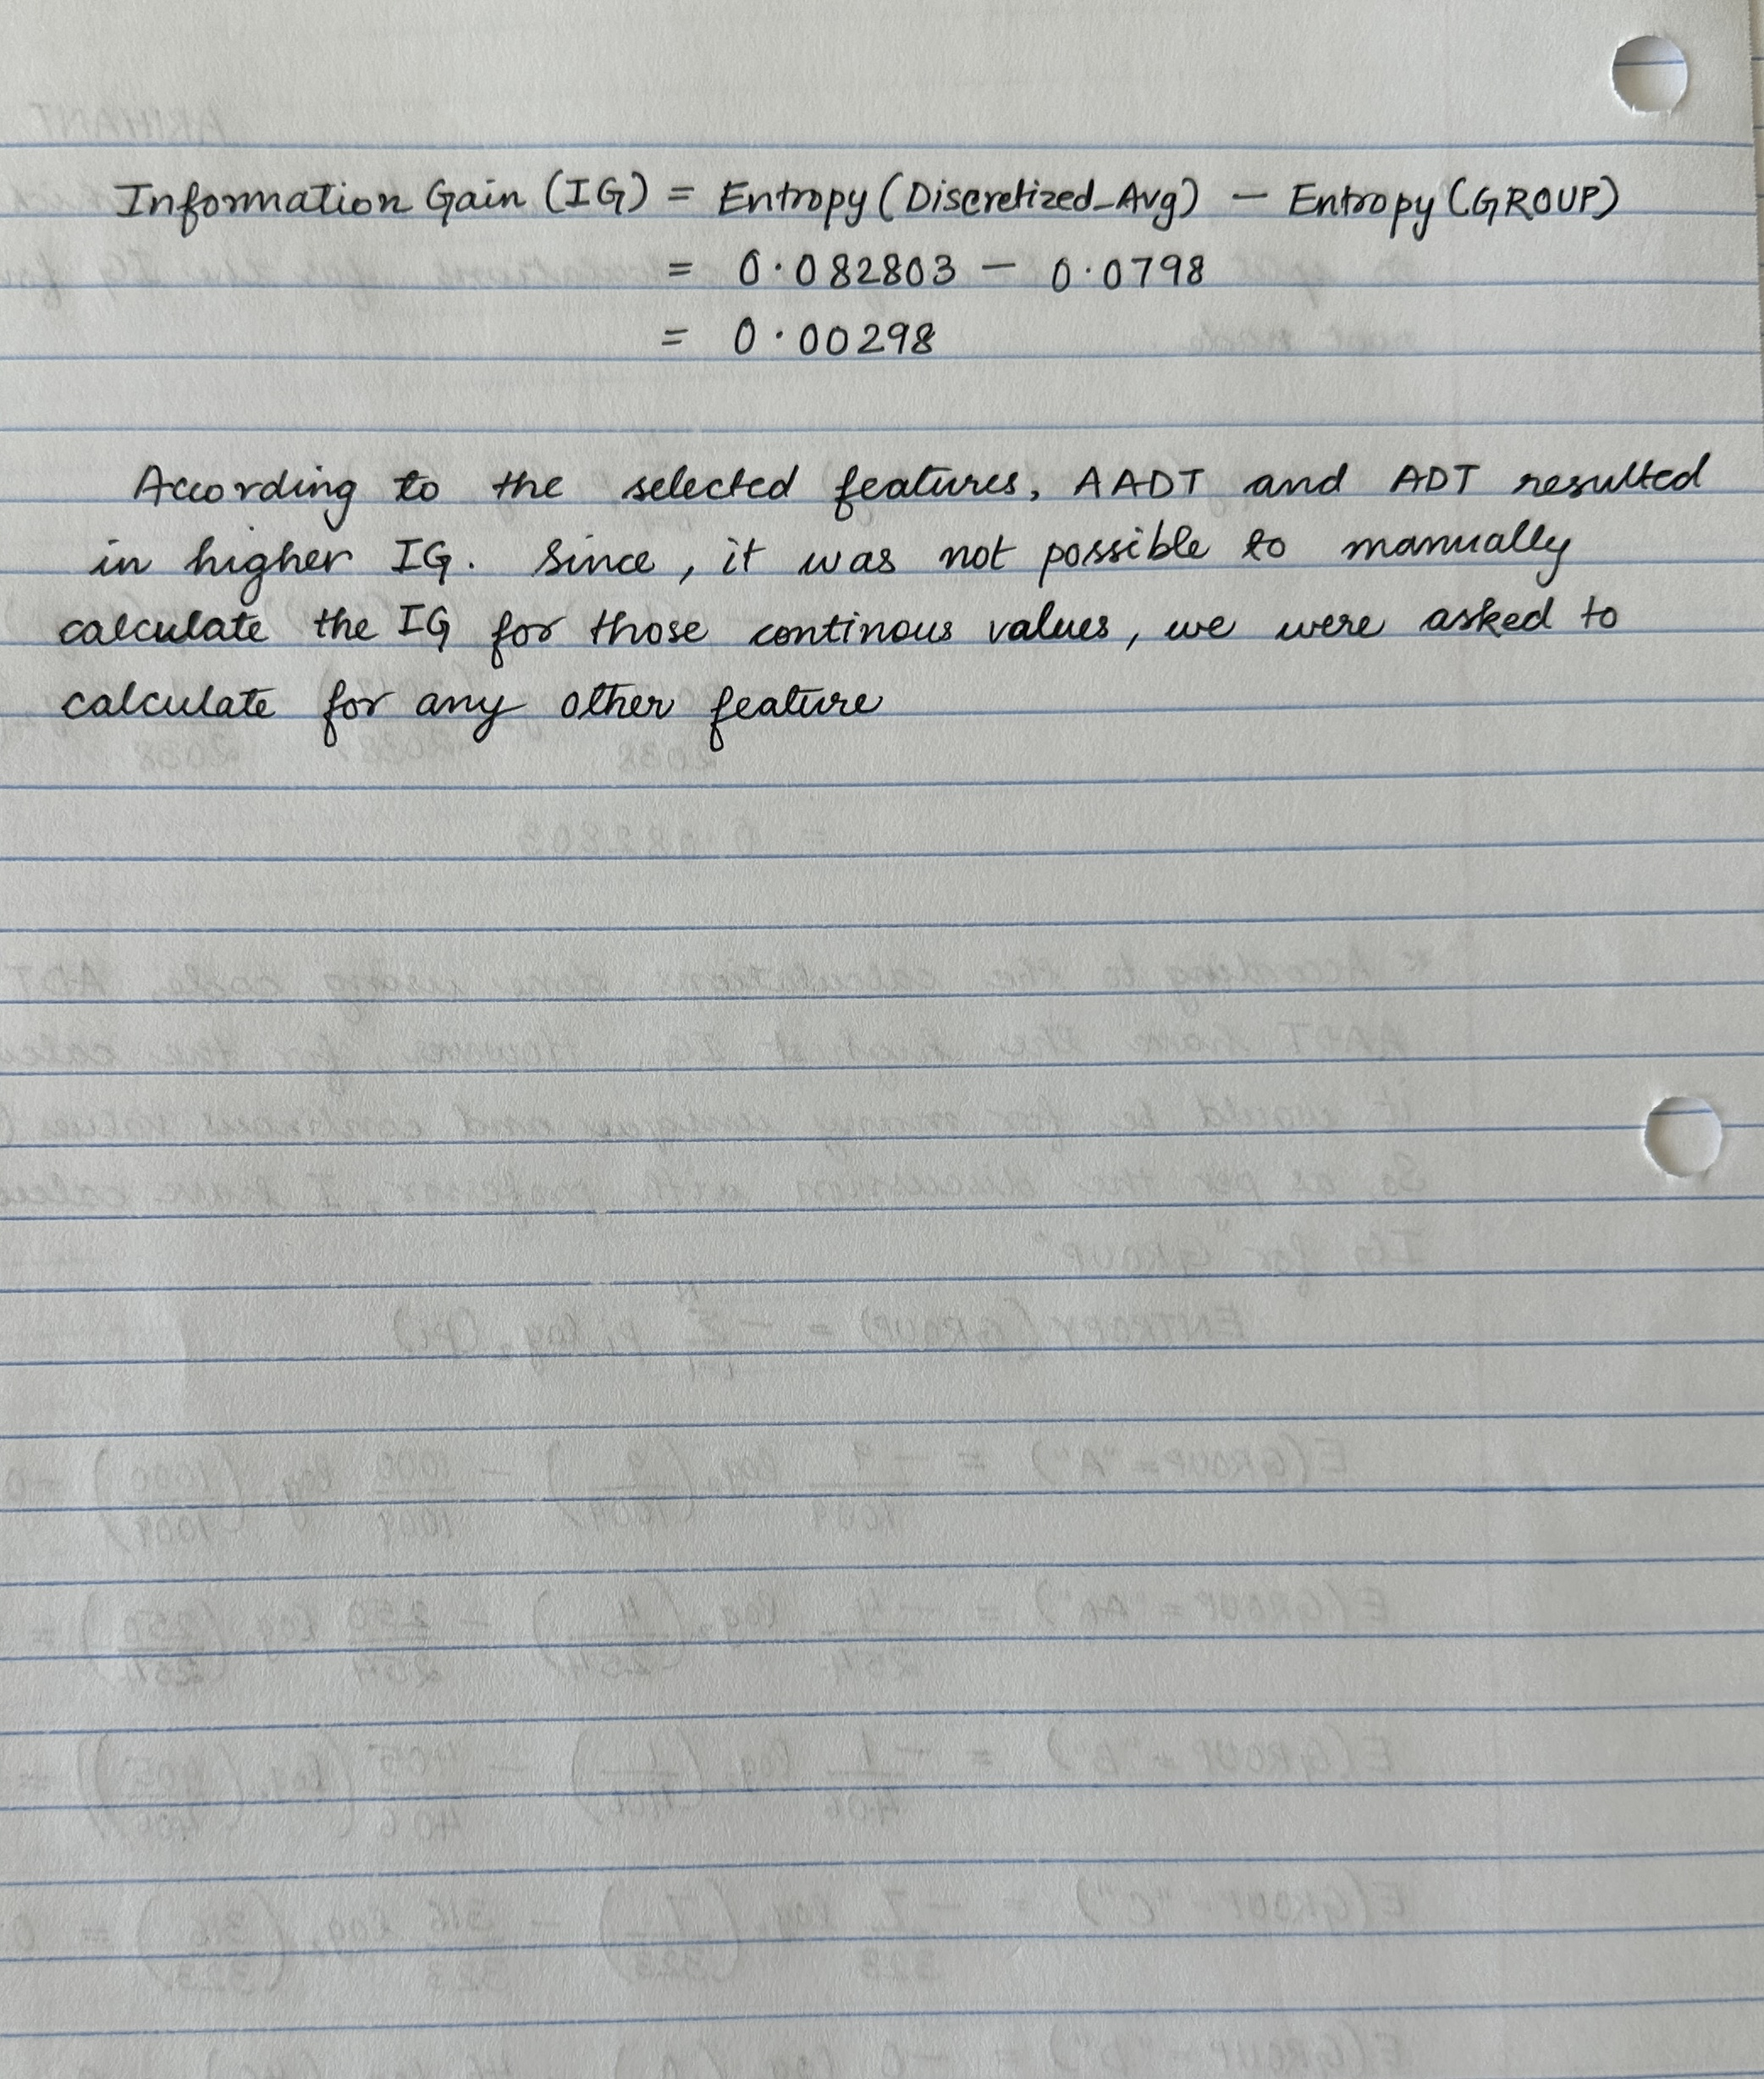

**ii. Repeat (i) using Gini Index criterion.**

In [11]:
print('\x1b[1;31m'+'Gini Index for each feature :'+'\x1b[0m')

for row in merged_df.iloc[:,:-3]:
    attr_entropy = 0
    for uniqval in np.unique(merged_df[row].values):
        unival_entropy = 0
        prob_high = len(merged_df[(merged_df[row] == uniqval) & (merged_df['Discretized_Avg'] == "High")]) / len(merged_df[(merged_df[row] == uniqval)])
        prob_low = len(merged_df[(merged_df[row] == uniqval) & (merged_df['Discretized_Avg'] == "Low")]) / len(merged_df[(merged_df[row] == uniqval)])
        prob_val = len(merged_df[(merged_df[row] == uniqval)]) / len(merged_df)
        unival_entropy += 1 - (prob_high**2) - (prob_low**2)
        # Calculate Average entropy Information
        attr_entropy += unival_entropy * prob_val
    print("Gini for {} is: {}".format(row,attr_entropy)) 

Gini Index for each feature :
Gini for HIGHWAY is: 0.019422107704508675
Gini for SECTION is: 0.020264523820600157
Gini for SECTION LENGTH is: 0.018883172190186127
Gini for SECTION DESCRIPTION is: 0.018883172190186127
Gini for DESCRIPTION is: 0.015054441796345623
Gini for GROUP is: 0.02031655007946334
Gini for TYPE is: 0.02038478897047249
Gini for ADT is: 0.0034254818819782597
Gini for AADT is: 0.012738523607022136


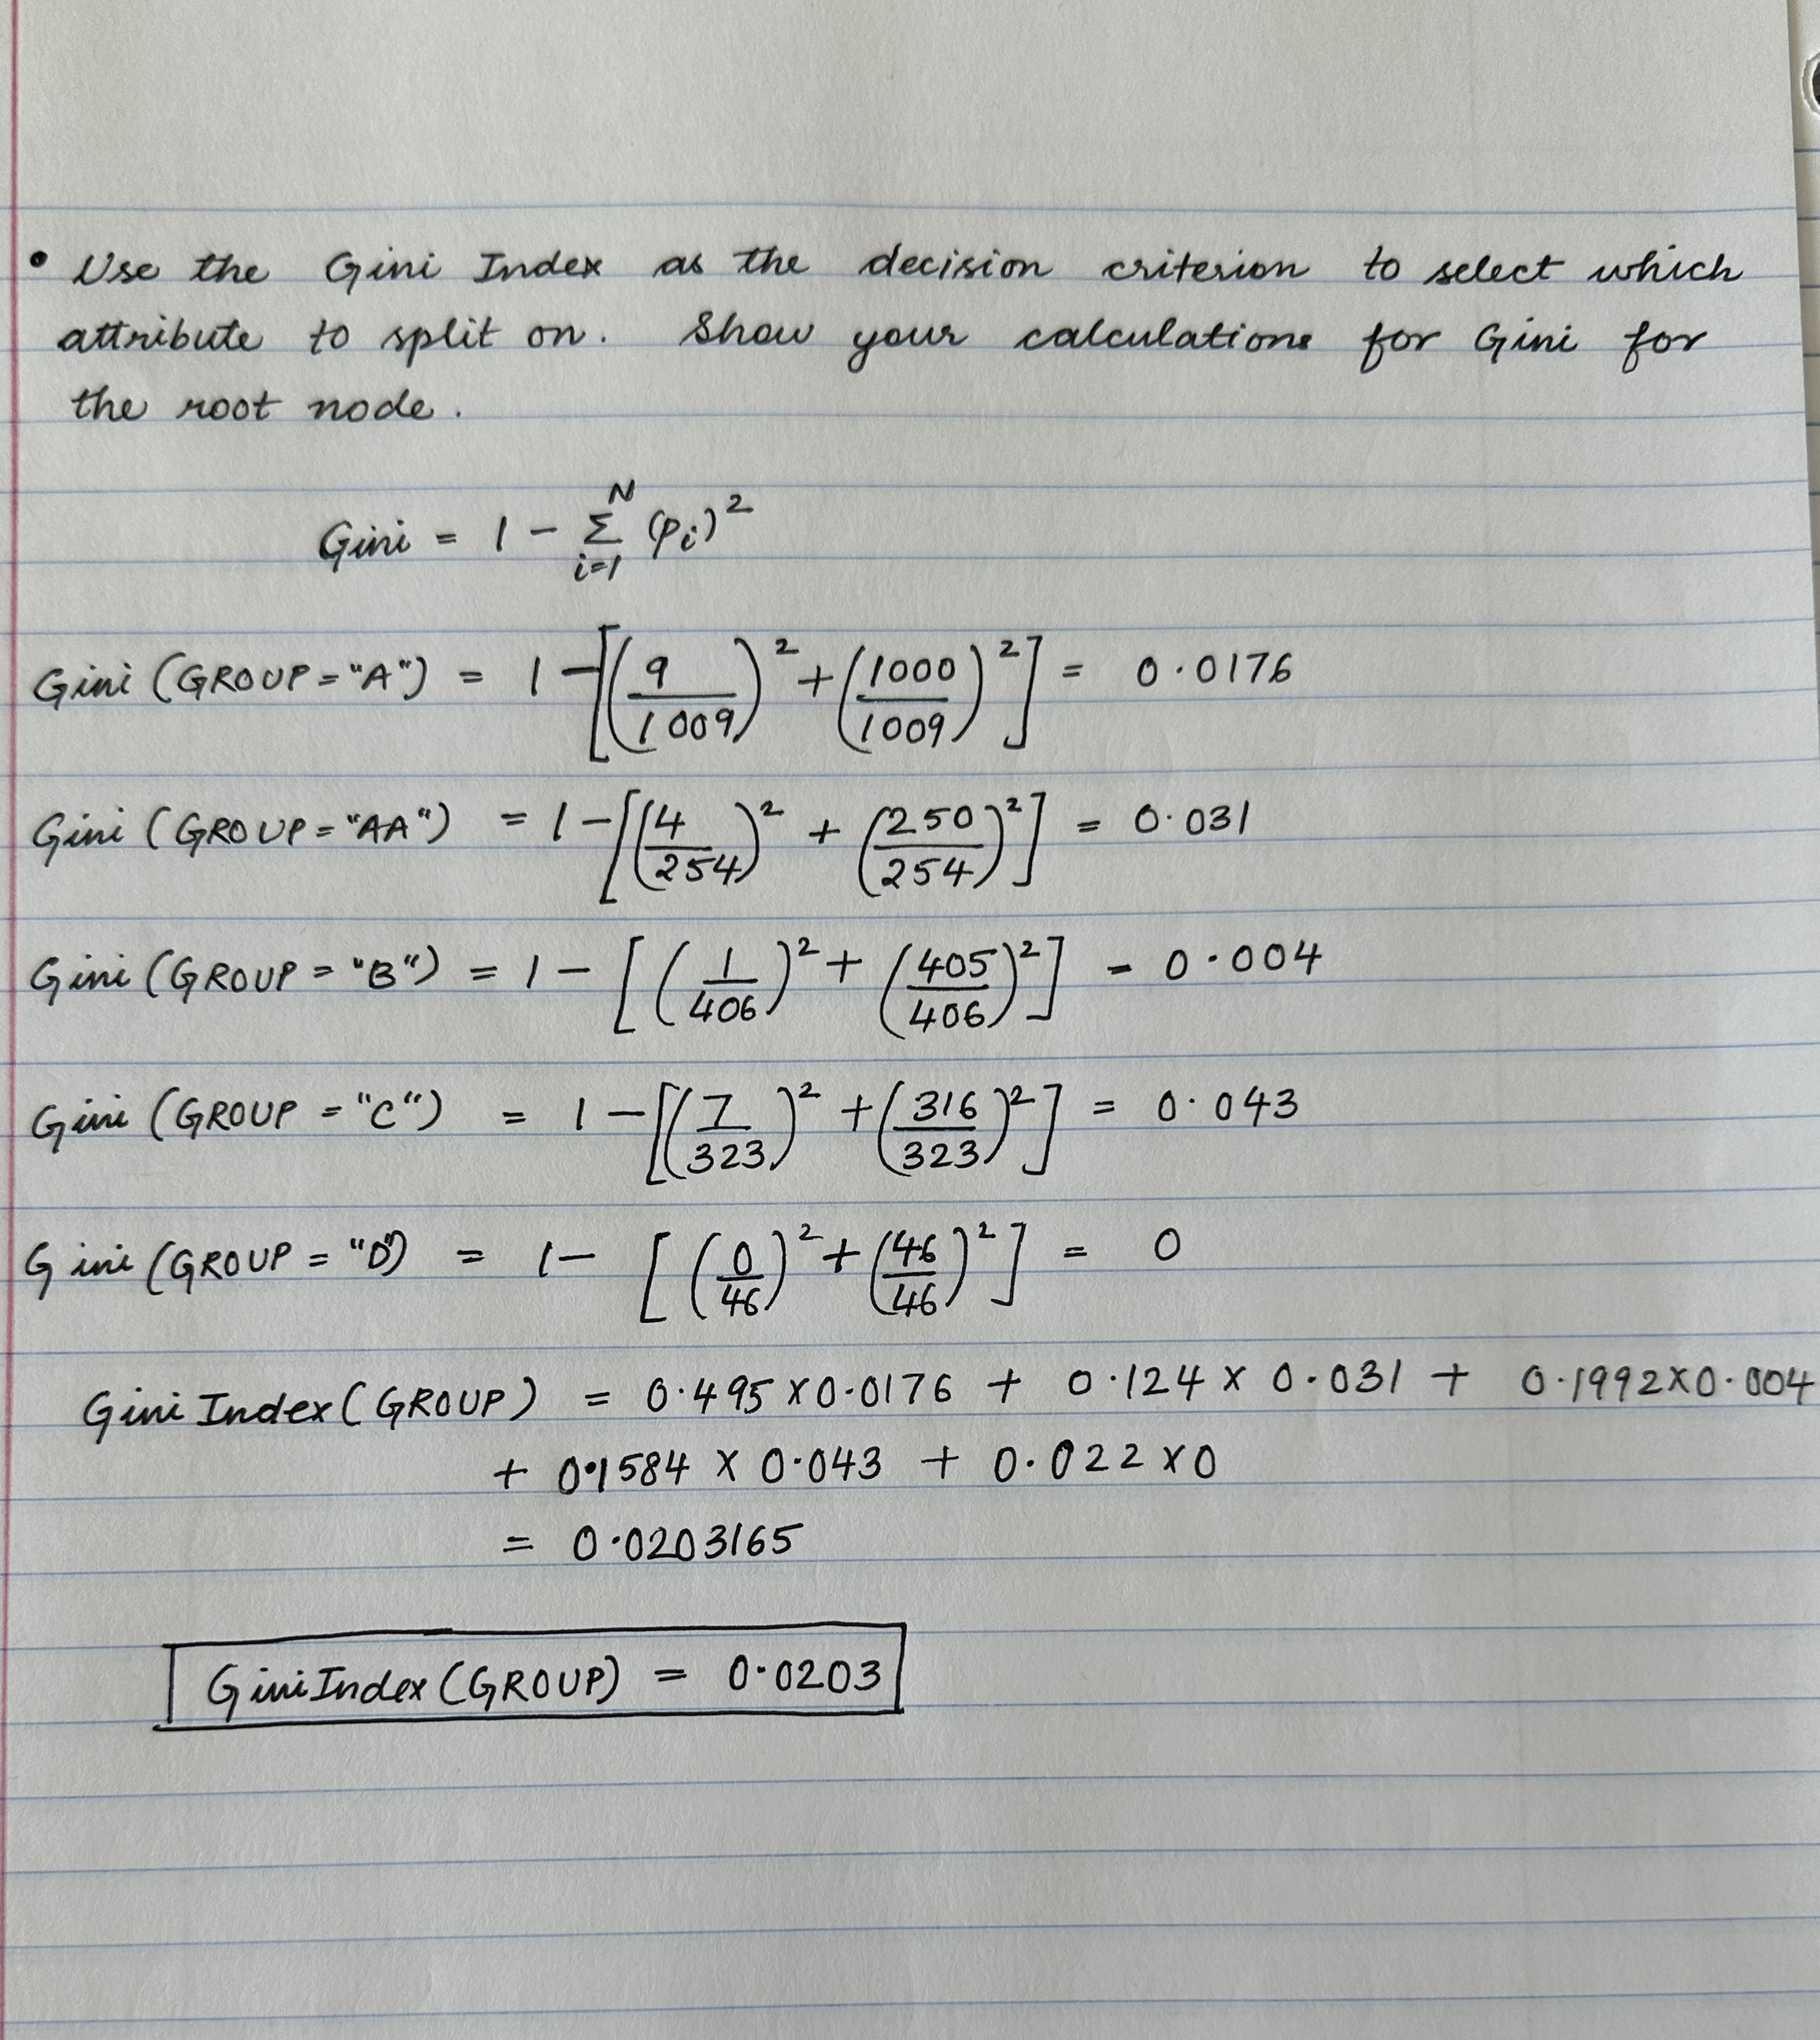

**iii. Create a decision tree**

In [12]:
#Create one-hot encoded columns for 'GROUP' and 'TYPE' in merged_df
merged_df_encoded = pd.get_dummies(merged_df, columns=['GROUP', 'TYPE'])
#Initialize the X value for training and testing and remove the columns that we will not be using to achieve a decision
X = merged_df_encoded.drop(columns=['Average', 'Discretized_Avg', 'Normalized_Avg', 'SECTION DESCRIPTION', 'DESCRIPTION', 'HIGHWAY'])
y = merged_df_encoded['Discretized_Avg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**a. Create a decision tree using IG with default parameters. Create confusion matrix and obtain accuracy, 
precision, recall, specificity, and f-measure.**

Criterion is entropy :
Accuracy is 0.9852941176470589
Recall is 0.9925925925925926
f1Score is 0.9852941176470589
Specificity is 0.0
Confusion Matrix :


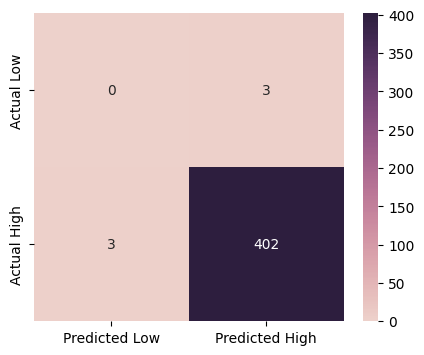

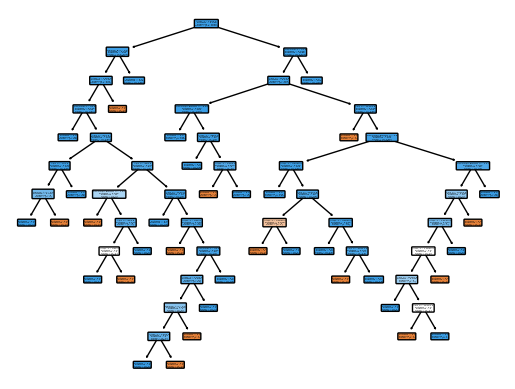

In [13]:
classifier = DecisionTreeClassifier(criterion = "entropy")
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)
truenegative, falsepositive, falsenegative, truepositive = matrix.ravel()

recall = recall_score(y_test, y_pred, pos_label="Low")
f1score = f1_score(y_test, y_pred, average="weighted")
specificity = truenegative / (truenegative + falsepositive)
print('\x1b[1;31m'+'Criterion is entropy :'+'\x1b[0m')
print('Accuracy is {}'.format(accuracy))
print('Recall is {}'.format(recall))
print('f1Score is {}'.format(f1score))
print('Specificity is {}'.format(specificity))
print('Confusion Matrix :')

plt.figure(figsize=(5,4))
sns.heatmap(
    matrix, annot = True,
    fmt='d', cmap=sns.cubehelix_palette(as_cmap=True),
    xticklabels=['Predicted Low', 'Predicted High'],
    yticklabels=['Actual Low', 'Actual High']
)
plt.show()

#Plot the tree using default values
plot_tree(classifier,filled=True,rounded=True,class_names=["Low","High"],feature_names=X.columns.to_list())
plt.show()

**b. Create a decision tree using Gini index with default parameters. Create confusion matrix and obtain accuracy, 
precision, recall, specificity, and f-measure.**

Criterion is gini :
Accuracy is 0.9901960784313726
Recall is 0.9975308641975309
f1Score is 0.9877571718342509
Specificity is 0.0
Confusion Matrix :


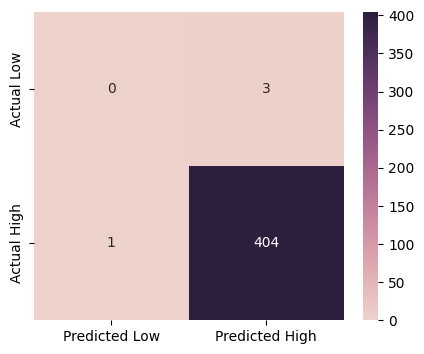

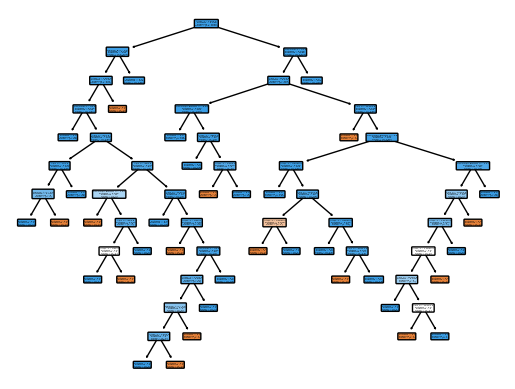

In [14]:
gini_classifier = DecisionTreeClassifier(criterion = "gini")
gini_classifier.fit(X_train, y_train)
y_pred = gini_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

truenegative, falsepositive, falsenegative, truepositive = matrix.ravel()

recall = recall_score(y_test, y_pred, pos_label="Low")
f1score = f1_score(y_test, y_pred, average="weighted")
specificity = truenegative / (truenegative + falsepositive)
print('\x1b[1;31m'+'Criterion is gini :'+'\x1b[0m')
print('Accuracy is {}'.format(accuracy))
print('Recall is {}'.format(recall))
print('f1Score is {}'.format(f1score))
print('Specificity is {}'.format(specificity))
print('Confusion Matrix :')

plt.figure(figsize=(5,4))
sns.heatmap(
    matrix, annot = True,
    fmt='d', cmap=sns.cubehelix_palette(as_cmap=True),
    xticklabels=['Predicted Low', 'Predicted High'],
    yticklabels=['Actual Low', 'Actual High']
)
plt.show()

#Plot the tree using default values
plot_tree(classifier,filled=True,rounded=True,class_names=["Low","High"],feature_names=X.columns.to_list())
plt.show()

**c. Explain which splitting criterion works well for your data and model and why.**

Gini index gives slightly higher results for the above evaluation metrics such as accuracy, recall and f1score. There could be certain things that we could consider for this:

-  Gini Impurity measures the probability of misclassifying a randomly chosen element from the dataset. It quantifies how often a randomly chosen element would be incorrectly classified. Whereas, Information Gain measures the reduction in entropy (uncertainty) achieved by partitioning a dataset based on a specific attribute. Entropy quantifies the randomness or impurity of a dataset.
-  Gini Impurity has a slightly higher recall (99.75% vs. 99.26%), indicating that it identifies a higher proportion of true positive instances, which can be crucial if we want to minimize false negatives.
-   Gini Impurity also has a higher F1-score (98.78% vs. 98.53%), which is the harmonic mean of precision and recall and provides a balanced measure of model performance.
-   Information Gain (IG) tends to favor the construction of deeper and more complex decision trees, placing a higher emphasis on capturing intricate patterns within the data. In contrast, Gini Impurity prioritizes the creation of shallower trees that emphasize class purity over reducing uncertainty.
-   Gini Impurity is often robust against class imbalances, often delivering satisfactory results even when the dataset exhibits significant class imbalances. On the other hand, Information Gain (IG) can be sensitive to class imbalances, potentially leading to biased splits. In our dataset, despite thorough cleaning, there may be instances where skewed class distributions could introduce imbalance, potentially affecting the outcomes in the confusion matrix.

**d. Find optimal max_depth, min_values_split, or min_values_leaf for your model with 5-fold cross validation**

In [15]:
# Define the hyperparameter grid to search within
param_grid = {
    'max_depth': np.arange(5,20),            # Try different values or None for no limit
    'min_samples_split': np.arange(2, 20),           # Minimum samples required to split a node
    'min_samples_leaf': np.arange(2, 20)             # Minimum samples required at a leaf node
}

# Create a DecisionTreeClassifier
classifier = DecisionTreeClassifier()

# Create GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to your data (X_train, y_train)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

# Fit a new model with the best hyperparameters on the entire training set
best_classifier = DecisionTreeClassifier(**best_params)
best_classifier.fit(X_train, y_train)

# Evaluate the model's performance on the test set
y_pred = best_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Print the best hyperparameters found by the grid search
print('\x1b[1;31m'+'Best Hyperparameters :'+'\x1b[0m')
print('Max Depth (max_depth) : {}'.format(best_params['max_depth']))
print('Min Sample Leaf (min_samples_leaf) : {}'.format(best_params['min_samples_leaf']))
print('Min Sample Split (min_samples_split) : {}'.format(best_params['min_samples_split']))

# Print the accuracy using the best hyperparameters found by the grid search
print('\x1b[1;31m'+'Accuracy on Test Set with Best Hyperparameters: '+'\x1b[0m', accuracy)

Best Hyperparameters :
Max Depth (max_depth) : 5
Min Sample Leaf (min_samples_leaf) : 5
Min Sample Split (min_samples_split) : 2
Accuracy on Test Set with Best Hyperparameters:  0.9926470588235294


**iv. Fit a Random Forest to your data. Evaluate and compare the results with (iii). Describe which model gives a better performance and explain the reason.**

Random Forest :
Accuracy is 0.9926470588235294
Recall is 1.0
f1Score is 0.9889841545474278
Specificity is 0.0
Confusion Matrix :


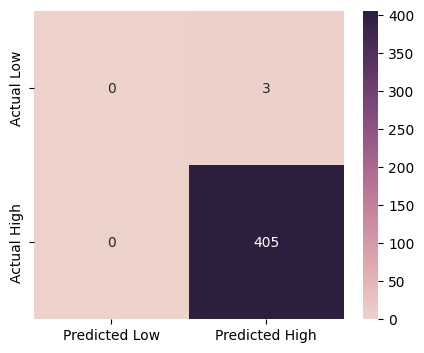

Comparison of results with (iii) :
Accuracy of Decision Tree is 0.9901960784313726
Accuracy of Random Forest is 0.9926470588235294


In [16]:
#Initialize the X value for training and testing and remove the columns that we will not be using to achieve a decision
X = merged_df_encoded.drop(columns=['Average', 'Discretized_Avg', 'Normalized_Avg', 'SECTION DESCRIPTION', 'DESCRIPTION', 'HIGHWAY'])
y = merged_df_encoded['Discretized_Avg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(max_depth=10, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate the accuracy of the classifier on the test set
accuracy = accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

truenegative, falsepositive, falsenegative, truepositive = matrix.ravel()

recall = recall_score(y_test, y_pred, pos_label="Low")
f1score = f1_score(y_test, y_pred, average="weighted")
specificity = truenegative / (truenegative + falsepositive)
print('\x1b[1;31m'+'Random Forest :'+'\x1b[0m')
print('Accuracy is {}'.format(accuracy))
print('Recall is {}'.format(recall))
print('f1Score is {}'.format(f1score))
print('Specificity is {}'.format(specificity))
print('Confusion Matrix :')

plt.figure(figsize=(5,4))
sns.heatmap(
    matrix, annot = True,
    fmt='d', cmap=sns.cubehelix_palette(as_cmap=True),
    xticklabels=['Predicted Low', 'Predicted High'],
    yticklabels=['Actual Low', 'Actual High']
)
plt.show()

gini_y_pred = gini_classifier.predict(X_test)
decision_tree_acc = accuracy_score(y_test, gini_y_pred)

print('\x1b[1;31m'+'Comparison of results with (iii) :'+'\x1b[0m')
print('Accuracy of Decision Tree is {}'.format(decision_tree_acc))
print('Accuracy of Random Forest is {}'.format(accuracy))


The Random Forest model outperformed the Decision Tree model when we used Gini as the basis for splitting. The Random Forest had higher accuracy, precision, recall, and F-measure values, indicating that it did a better job classifying instances while balancing precision and recall.

In addition, the confusion matrix revealed that the Random Forest model had more true positives and true negatives, demonstrating overall better performance.

The improved performance of Random Forest could be attributed to its ensemble nature. It combines multiple decision trees to make more accurate predictions. Each tree is constructed from a sample drawn from the training set, and when splitting nodes, it considers either all input features or a random subset. This randomness reduces variance and helps prevent overfitting, which Decision Trees are prone to. Random Forest's averaging of multiple trees trained on different parts of the training set enhances predictive accuracy and reduces overfitting, contributing to its superior performance in this case.

### References :
[1] IBM documentation. (2021, April 8). Ibm.com. https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet <br>[2] seaborn.PairGrid — seaborn 0.13.0 documentation. (n.d.). Pydata.org. Retrieved October 3, 2023, from https://seaborn.pydata.org/generated/seaborn.PairGrid.html <br>
[3] Seaborn.Heatmap — seaborn 0.13.0 documentation. (n.d.). Pydata.org. Retrieved October 3, 2023, from https://seaborn.pydata.org/generated/seaborn.heatmap.html <br>
[4] Koehrsen, W. (2018, January 10). Hyperparameter tuning the random forest in python. Towards Data Science. https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 <br>[5] Sklearn.tree.decisionTreeClassifier. (n.d.). Scikit-Learn. Retrieved October 3, 2023, from https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html <br>
[6] Mithrakumar, M. (2019, November 11). How to tune a decision tree? Towards Data Science. https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680 <br>
[7] Python, R. (2018, March 26). Pythonic Data Cleaning With pandas and NumPy. Realpython.com; Real Python. https://realpython.com/python-data-cleaning-numpy-pandas/







